In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('co2_mm_mlo.csv')

### Inspect the data, create a DatetimeIndex

In [2]:
df

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86
...,...,...,...,...,...
724,2018,7,2018.542,408.71,408.71
725,2018,8,2018.625,406.99,406.99
726,2018,9,2018.708,405.51,405.51
727,2018,10,2018.792,406.00,406.00


In [3]:
# Add a "date" datetime column
df['date'] = pd.to_datetime(dict(year = df['year'], month = df['month'], day = 1))

In [4]:
# Set "date" to be the index
df.set_index('date', inplace = True)
df.index.freq = 'MS'
df

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86
...,...,...,...,...,...
2018-07-01,2018,7,2018.542,408.71,408.71
2018-08-01,2018,8,2018.625,406.99,406.99
2018-09-01,2018,9,2018.708,405.51,405.51


### Plot the source data

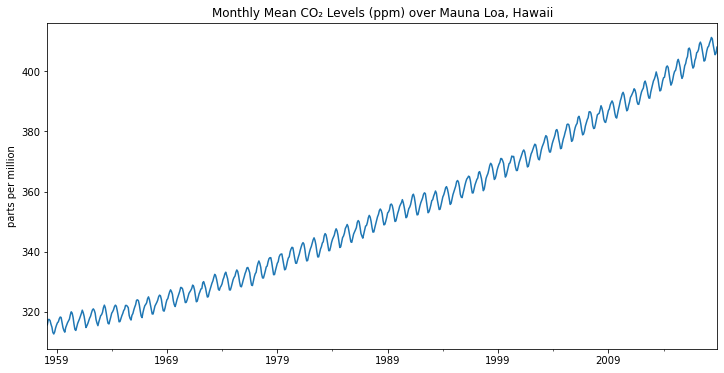

In [5]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel = 'parts per million'
xlabel = ''

ax = df['interpolated'].plot(figsize = (12, 6), title = title)
ax.set(xlabel = xlabel, ylabel = ylabel);

### Run an ETS Decomposition

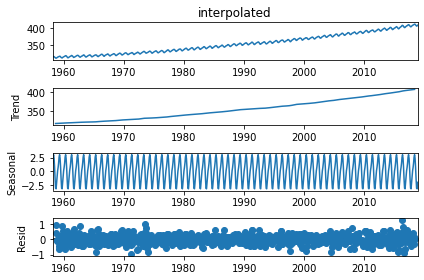

In [6]:
result = seasonal_decompose(df['interpolated'], model = 'add')
result.plot();

Although small in scale compared to the overall values, there is a definite annual seasonality.

### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders

In [7]:
auto_arima(df['interpolated'], seasonal = True, m = 12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -206.252
Date:                            Sat, 19 Nov 2022   AIC                            424.503
Time:                                    16:33:37   BIC                            452.045
Sample:                                03-01-1958   HQIC                           435.130
                                     - 11-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3516      0.072      4.876      0.000       0.210       0.493
ar.L2          0.0876      0.037      2.335      0.020       0.014       0.161
ma.L1         -0.7068      0.067    -10.597      0.000      -0.838      -0.576
ar.S.L12       0.9996      0.000   2956.324      0.000       0.999       1.000
ma.S.L12      -0.8667      0.021    -40.595      0.000      -0.909      -0.825
sigma2         0.0957      0.005     20.315      0.000       0.086       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 4.48
Prob(Q):                              0.79   Prob(JB):                         0.11
Heteroskedasticity (H):               1.13   Skew:                            -0.00
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This provides an ARIMA Order of (2,1,1) combined with a seasonal order of (1,0,1,12).
### Split the data into train/test sets

In [8]:
len(df)

729

In [9]:
# Set one year for testing
train = df.iloc[:717]
test = df.iloc[717:]

### Fit a SARIMA(2,1,1)(1,0,1,12) Model

In [10]:
model = SARIMAX(train['interpolated'], order = (2, 1, 1), seasonal_order = (1, 0, 1, 12))
results = model.fit()
results.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.01395D-01    |proj g|=  6.33009D-01

At iterate    5    f=  5.64002D-01    |proj g|=  2.15618D-01

At iterate   10    f=  3.10141D-01    |proj g|=  1.23162D-01

At iterate   15    f=  2.94184D-01    |proj g|=  2.99665D-02

At iterate   20    f=  2.91070D-01    |proj g|=  6.95370D-03

At iterate   25    f=  2.90506D-01    |proj g|=  2.28674D-02

At iterate   30    f=  2.89978D-01    |proj g|=  9.58915D-03

At iterate   35    f=  2.89704D-01    |proj g|=  3.25107D-02

At iterate   40    f=  2.83119D-01    |proj g|=  6.98993D-02

At iterate   45    f=  2.81603D-01    |proj g|=  1.24913D-02

At iterate   50    f=  2.81570D-01    |proj g|=  1.14676D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -201.886
Date:                            Sat, 19 Nov 2022   AIC                            415.771
Time:                                    16:35:22   BIC                            443.213
Sample:                                03-01-1958   HQIC                           426.368
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3456      0.038      8.990      0.000       0.270       0.421
ar.L2          0.0837      0.030      2.807      0.005       0.025       0.142
ma.L1         -0.7008      0.037    -19.018      0.000      -0.773      -0.629
ar.S.L12       0.9996      0.000   2817.762      0.000       0.999       1.000
ma.S.L12      -0.8665      0.023    -38.478      0.000      -0.911      -0.822
sigma2         0.0953      0.005     20.235      0.000       0.086       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 4.68
Prob(Q):                              0.83   Prob(JB):                         0.10
Heteroskedasticity (H):               1.14   Skew:                             0.01
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
# Obtain predicted values
start = len(train)
end = len(df) - 1
predictions = results.predict(start = start, end = end, dynamic = False, typ = 'levels').rename('SARIMA(2,1,1)(1,0,1,12) Predictions')

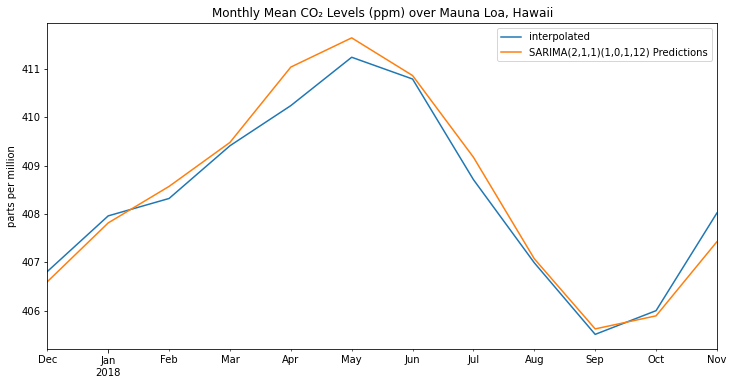

In [13]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel = 'parts per million'
xlabel = ''

ax = test['interpolated'].plot(legend = True,figsize = (12, 6), title = title)
predictions.plot(legend = True)
ax.set(xlabel = xlabel, ylabel = ylabel);

### Evaluate the Model

In [14]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['interpolated'], predictions)
print(f'SARIMA(2,1,1)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(2,1,1)(1,0,1,12) MSE Error: 0.1276503891


In [15]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['interpolated'], predictions)
print(f'SARIMA(2,1,1)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(2,1,1)(1,0,1,12) RMSE Error: 0.3572819462


In [16]:
test['interpolated'].mean()

408.3333333333333

Errors are extremely low compared with the mean.

### Retrain the model on the full data, and forecast the future

In [17]:
model = SARIMAX(df['interpolated'],order = (2, 1, 1),seasonal_order = (1, 0, 1, 12))
results = model.fit()
forecast = results.predict(len(df), len(df) + 11, typ = 'levels').rename('SARIMA(2,1,1)(1,0,1,12) Forecast')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.97985D-01    |proj g|=  6.23769D-01

At iterate    5    f=  5.54602D-01    |proj g|=  2.10287D-01

At iterate   10    f=  3.12035D-01    |proj g|=  3.93367D-02

At iterate   15    f=  3.06254D-01    |proj g|=  8.62697D-03

At iterate   20    f=  3.04920D-01    |proj g|=  1.66373D-01

At iterate   25    f=  3.00714D-01    |proj g|=  1.46897D-02

At iterate   30    f=  3.00449D-01    |proj g|=  2.18364D-02

At iterate   35    f=  2.87724D-01    |proj g|=  3.74549D-02

At iterate   40    f=  2.82977D-01    |proj g|=  1.66002D-02

At iterate   45    f=  2.82924D-01    |proj g|=  2.48240D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

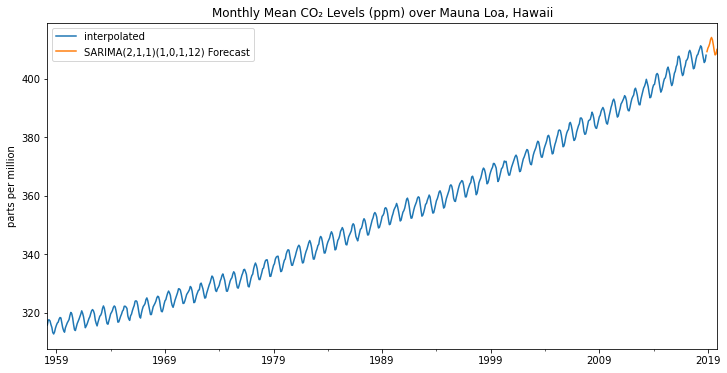

In [18]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel = 'parts per million'
xlabel = ''

ax = df['interpolated'].plot(legend = True, figsize = (12, 6), title = title)
forecast.plot(legend = True)
ax.set(xlabel = xlabel, ylabel = ylabel);